In [7]:

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import json
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

# Main Paths
INPUT_PATH = Path('/kaggle/input/human-faces-object-detection')
WORKING_PATH = Path('/kaggle/working/yolo_dataset')
IMAGES_SRC = INPUT_PATH / 'images'
CSV_FILE = INPUT_PATH / 'faces.csv'

print("Setup complete. Ready to process data.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete. Ready to process data.


In [8]:
df = pd.read_csv(CSV_FILE)
print(f"Total annotations in CSV: {len(df)}")
print(f" Unique images: {df['image_name'].nunique()}")

# Calculate basic stats
face_counts = df.groupby('image_name').size()
print(f"✓ Average faces per image: {face_counts.mean():.2f}")
print(f"✓ Maximum faces in one image: {face_counts.max()}")

# Visualize first 5 rows
df.head()

Total annotations in CSV: 3350
 Unique images: 2204
✓ Average faces per image: 1.52
✓ Maximum faces in one image: 12


,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [9]:
# 1. Create Folders
for split in ['train', 'val', 'test']:
    (WORKING_PATH / 'images' / split).mkdir(parents=True, exist_ok=True)
    (WORKING_PATH / 'labels' / split).mkdir(parents=True, exist_ok=True)

# 2. Split Images
unique_images = df['image_name'].unique()
train_val, test_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)
train_imgs, val_imgs = train_test_split(train_val, test_size=0.15, random_state=42)

splits = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

# 3. Process and Copy
print(" Processing and copying files...")
for split_name, img_list in splits.items():
    for img_name in img_list:
        # Copy Image
        if (IMAGES_SRC / img_name).exists():
            shutil.copy(IMAGES_SRC / img_name, WORKING_PATH / 'images' / split_name / img_name)
            
            # Create YOLO Label (.txt)
            img_data = df[df['image_name'] == img_name]
            label_path = WORKING_PATH / 'labels' / split_name / f"{Path(img_name).stem}.txt"
            
            with open(label_path, 'w') as f:
                for _, row in img_data.iterrows():
                    x_center = ((row['x0'] + row['x1']) / 2) / row['width']
                    y_center = ((row['y0'] + row['y1']) / 2) / row['height']
                    w_box = (row['x1'] - row['x0']) / row['width']
                    h_box = (row['y1'] - row['y0']) / row['height']
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {w_box:.6f} {h_box:.6f}\n")

# 4. Create data.yaml
yaml_content = f"path: {WORKING_PATH.absolute()}\ntrain: images/train\nval: images/val\ntest: images/test\nnc: 1\nnames: ['face']"
with open(WORKING_PATH / 'data.yaml', 'w') as f:
    f.write(yaml_content)

print(f" Dataset ready! Saved at: {WORKING_PATH}")

 Processing and copying files...
 Dataset ready! Saved at: /kaggle/working/yolo_dataset


In [10]:
model = YOLO('yolov8n.pt')

# Start training
results = model.train(
    data=str(WORKING_PATH / 'data.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    name='face_model',
    device=0
)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=face_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

In [14]:
import random

def show_model_results(model, split='test', blur_faces=True, n_images=3):
    img_paths = list((WORKING_PATH / 'images' / split).glob('*.jpg'))
    selected_imgs = random.sample(img_paths, min(n_images, len(img_paths)))
    
    for img_path in selected_imgs:
        img = cv2.imread(str(img_path))
        results = model(img)
        
        img_copy = img.copy()
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                if blur_faces and (y2-y1>0 and x2-x1>0):
                    face = img_copy[y1:y2, x1:x2]
                    img_copy[y1:y2, x1:x2] = cv2.GaussianBlur(face, (51,51), 0)
                else:
                    cv2.rectangle(img_copy, (x1,y1), (x2,y2), (0,255,0), 2)
        
        plt.figure(figsize=(8,8))
        plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"{split.upper()} Image: {img_path.name}")
        plt.axis('off')
        plt.show()



0: 640x448 1 face, 37.1ms
Speed: 2.5ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


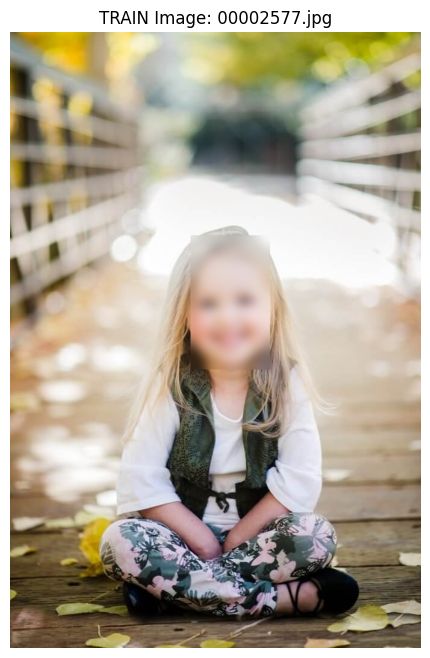


0: 448x640 1 face, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


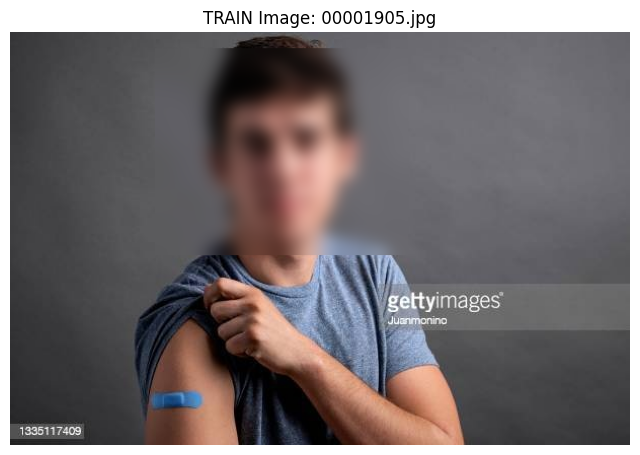

In [17]:
show_model_results(best_model, split='train', blur_faces=True, n_images=2)



0: 448x640 4 faces, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


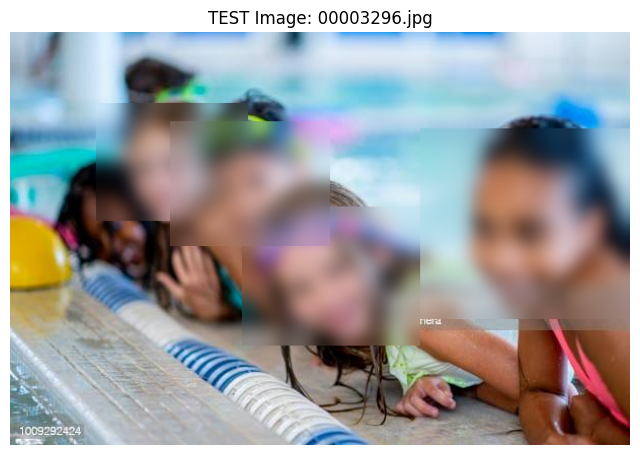


0: 480x640 1 face, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


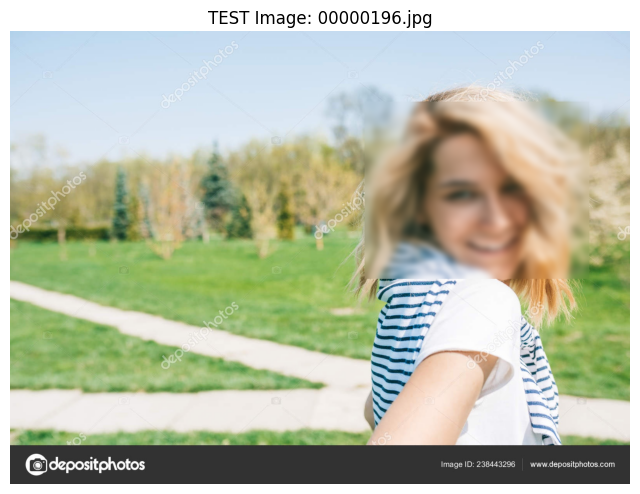

In [19]:
show_model_results(best_model, split='test', blur_faces=True, n_images=2)


In [22]:
import gradio as gr
import cv2
import numpy as np
from PIL import Image

# Function to process image with YOLO model and apply face blur
def yolo_blur(img):
    # Convert PIL image to OpenCV format
    img = np.array(img)
    img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Run YOLO inference
    results = best_model(img_cv)
    
    # Copy image for output
    img_out = img_cv.copy()
    
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face = img_out[y1:y2, x1:x2]
            if face.size > 0:
                # Apply Gaussian blur to the detected face
                img_out[y1:y2, x1:x2] = cv2.GaussianBlur(face, (51,51), 0)
    
    # Convert back to PIL for Gradio display
    img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_out)

# Create Gradio interface
iface = gr.Interface(
    fn=yolo_blur,                  # The function that processes the image
    inputs=gr.Image(type="pil"),   # Input type: image
    outputs=gr.Image(type="pil"),  # Output type: image
    title="YOLOv8 Face Blur Demo",
    description="Upload any image, and the model will detect faces and apply blur."
)

# Launch the interface
iface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://0d1f635ce82da9efda.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



0: 640x480 1 face, 43.0ms
Speed: 3.5ms preprocess, 43.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 face, 6.4ms
Speed: 3.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 1 face, 36.8ms
Speed: 2.3ms preprocess, 36.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)
